In [ ]:
!pip install mtcnn

In [2]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./images"))

# Any results you write to the current directory are saved as output.

['leonard', 'penny', 'sheldon']


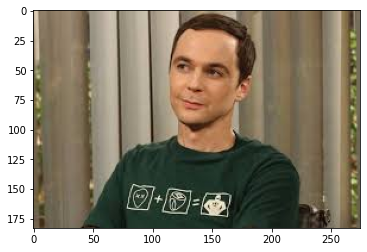

(183, 275, 3)


In [43]:
img = cv2.imread('./images/sheldon/1.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

1/1 [==============================] - 0s 176ms/step


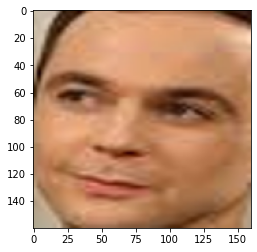

(160, 160, 3)


In [22]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('./images/sheldon/1.jpeg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [23]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('./images/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('./test/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('dataset.npz', trainX, trainy, testX, testy)

1/1 [==============================] - 0s 105ms/step
loaded 6 sample for class: leonard
1/1 [==============================] - 0s 113ms/step
loaded 7 sample for class: penny
1/1 [==============================] - 0s 109ms/step
loaded 6 sample for class: sheldon
(19, 160, 160, 3) (19,)
1/1 [==============================] - 0s 111ms/step
loaded 2 sample for class: leonard
1/1 [==============================] - 0s 115ms/step
loaded 2 sample for class: sheldon
(4, 160, 160, 3) (4,)


In [24]:
data = np.load('dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (19, 160, 160, 3) (19,) (4, 160, 160, 3) (4,)


In [25]:
from keras_facenet import FaceNet

In [26]:
facenet_model = FaceNet()
print('Loaded Model')

Loaded Model


In [27]:
def get_embedding(model, face):
    # scale pixel values
    # face = face.astype('float32')
    # standardization
    # mean, std = face.mean(), face.std()
    # face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.embeddings(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('embeddings.npz', emdTrainX, trainy, emdTestX, testy)

1/1 [==============================] - 0s 60ms/step
(19, 512)
1/1 [==============================] - 0s 59ms/step
(4, 512)


In [32]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=19, test=4
Accuracy: train=100.000, test=100.000


In [33]:
yhat_test

array([0, 0, 2, 2])

In [34]:
# inverse transform
yhat_test = out_encoder.inverse_transform(yhat_test)
yhat_test

array(['leonard', 'leonard', 'sheldon', 'sheldon'], dtype='<U7')

1/1 [==============================] - 0s 51ms/step


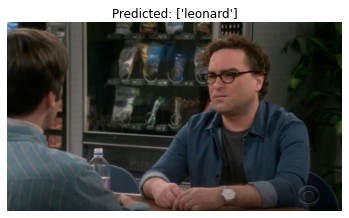

1/1 [==============================] - 0s 46ms/step


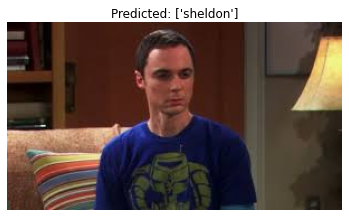

1/1 [==============================] - 0s 47ms/step


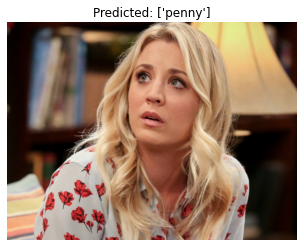

In [49]:
image = ['./test/leonard/7.jpg', './test/sheldon/2.jpeg','./test/penny/2.jpg']

for i in range(len(image)):
    # test this image
    pixels = extract_face(image[i])
    # convert into embedding
    embedding = get_embedding(facenet_model, pixels)
    # get label
    embedding_norm = in_encoder.transform(np.expand_dims(embedding, axis=0))
    yhat_class = model.predict(embedding_norm)

    plt.imshow(cv2.cvtColor(cv2.imread(image[i]), cv2.COLOR_BGR2RGB))
    # inverse transform predict name
    plt.title('Predicted: %s' % (out_encoder.inverse_transform(yhat_class)))
    plt.axis('off')
    plt.show()
    # yhat_class
